In [40]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

In [41]:
# %load_ext blackcellmagic
# todo custom loss to bump up brigtness
dataDir = "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform' ##
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training
colorspace = ['lab','rgb','hsv'][0]
rgb = colorspace == 'rgb'
lab = colorspace == 'lab'

In [159]:
def showHsv(img):    
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif lab:
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

def saturationLoss(yTrue, yPred):
    multiplier = 1 / K.sqrt(K.abs( (yPred[...,0] - 128) * (yPred[...,1] - 128)) +0.1)
    a =  K.square(yTrue[...,0] - yPred[...,0]) 
    b =  K.square(yTrue[...,1] - yPred[...,1]) 
    return K.concatenate([a*multiplier, b*multiplier], axis=-1)
    
    

In [136]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB if lab else cv2.COLOR_BGR2HSV)
print(hsv.shape)
print('''LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.''')
h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)
LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.


In [45]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation) or (blue, green, red) or (L, A, B)
    '''
    img_in = cv2.imread(path)
    if lab:
        LAB = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(LAB)
        return l, np.dstack((a,b))
        
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    if rgb:
        b,g,r = cv2.split(img_in)
        Y = np.dstack((b,g,r))
    else:
        Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [172]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 3 if rgb else 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.8 # 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.002 # 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)
print(params['mean'].shape)

dataset size 202599
train len 162079
val len 405
(32, 128, 128, 2)
(128, 128, 3)


In [52]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(3 if rgb else 2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 128, 128, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_171[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_172[0][0]                 
__________________________________________________________________________________________________
conv2d_173

In [ ]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
predictFromImage(f'data/resized/{trainSize:06}.jpg', True)

In [177]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# model.save_weights('lab_big_train_set.h5')
# countEpochs = 1
# model.load_weights('good_lab_trained8epochs.h5')

In [171]:
model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                  metrics=['mae','mse'])

In [173]:
for i in range(1,3):
    #start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
#     predictFromImage(f'data/resized/{i+18:06}.jpg', True)

Epoch 14/14
5064/5064 [==============================] - 1314s 260ms/step - loss: 6.6844 - mean_absolute_error: 6.6844 - mean_squared_error: 110.6881 - val_loss: 6.5043 - val_mean_absolute_error: 6.5043 - val_mean_squared_error: 104.7638
Epoch 15/15
5064/5064 [==============================] - 1293s 255ms/step - loss: 6.4947 - mean_absolute_error: 6.4947 - mean_squared_error: 107.7425 - val_loss: 6.3497 - val_mean_absolute_error: 6.3497 - val_mean_squared_error: 102.0921


In [97]:
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    if rgb:
        RGB, v = hs[0], v[0,...,0]
        print('rgb.shape',RGB.shape)
        img = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)
    else:
        hs, v = hs[0], v[0,...,0]
        #print('hs:',hs.shape)
        h, s = hs[...,0], hs[...,1]
        #h = mapOutOfGreen(h)
        #print('h',h.shape,'s',s.shape,'v',v.shape)
        #print(h.dtype, s.dtype, v.dtype)
        hsv = cv2.merge([v,h,s] if lab else [h,s,v] )
        img = cv2.cvtColor(hsv, cv2.COLOR_LAB2RGB if lab else cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4 + 1*rgb, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    titles = ['blue', 'green', 'red','value'] if rgb else ['A','B','L'] if lab else ['hue', 'saturation', 'value']
    for i in range(3 if rgb else 2,-1,-1):
        if rgb:
            pic = RGB[:,:,i] if i < 3 else v
        elif lab:
            pic = hsv[:,:,-i-1]
        else:
            pic = hsv[:,:,i]
        axarr[1+i].title.set_text(titles[i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    inX, inY = loadImgHsv(img )
    inX, inY = inX[None,...,None], inY[None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)
    if not rgb:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('hue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
        print('sat:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    else:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('red:',predY[...,2].min(), predY[...,2].max(), predY[...,2].mean() )
        print('green:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
        print('blue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        if not rgb:
            predY[...,0] = predY[...,0] % 181
        else:
            predY = np.minimum(predY, 255)
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    if not rgb:
        hue = predY[...,0]
        print('hue uint8',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        predictFromImage(f'data/resized/{i:06}.jpg', True)

countEpochs 15
predy 126.79721 154.67474 138.36667 (1, 128, 128, 2)
hue: 128.34842 152.6692 137.72586
sat: 126.79721 154.67474 139.00748
predy uint8 126 154 137.863037109375
hue uint8 128 152 137.22607421875


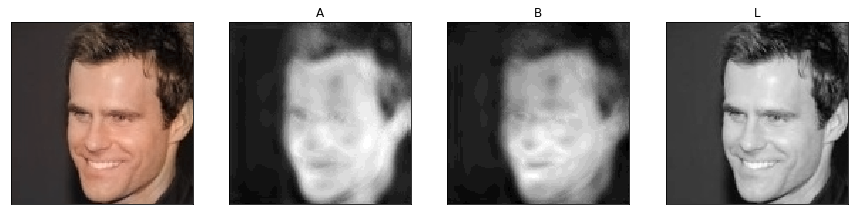

predy 128.18977 153.5031 139.27057 (1, 128, 128, 2)
hue: 128.18977 153.27599 137.7898
sat: 128.64229 153.5031 140.75137
predy uint8 128 153 138.76611328125
hue uint8 128 153 137.285888671875


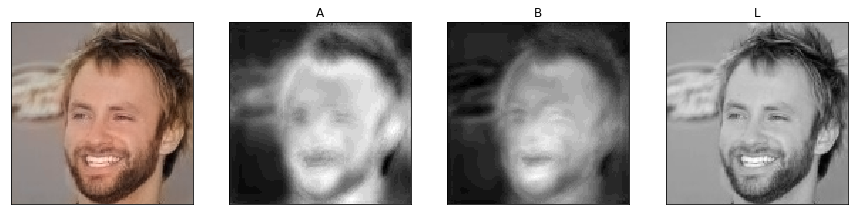

predy 126.49491 154.01326 139.02473 (1, 128, 128, 2)
hue: 128.27544 153.95844 136.96062
sat: 126.49491 154.01326 141.08887
predy uint8 126 154 138.52359008789062
hue uint8 128 153 136.4591064453125


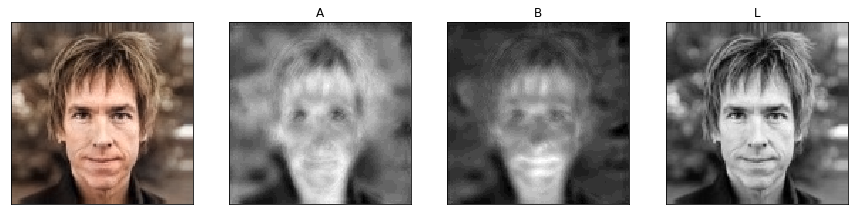

predy 127.646416 156.59364 140.22441 (1, 128, 128, 2)
hue: 127.646416 151.01312 137.66829
sat: 128.18178 156.59364 142.78055
predy uint8 127 156 139.72171020507812
hue uint8 127 151 137.16241455078125


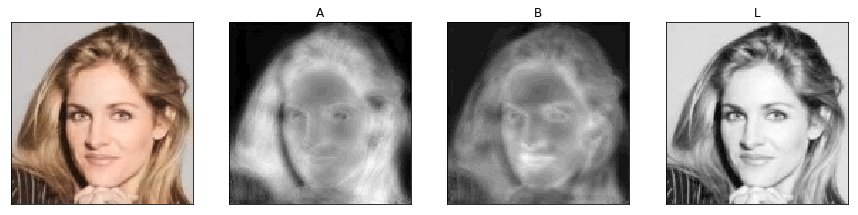

predy 127.78983 154.04387 140.27025 (1, 128, 128, 2)
hue: 127.78983 150.93921 138.43922
sat: 128.21713 154.04387 142.10129
predy uint8 127 154 139.77114868164062
hue uint8 127 150 137.94000244140625


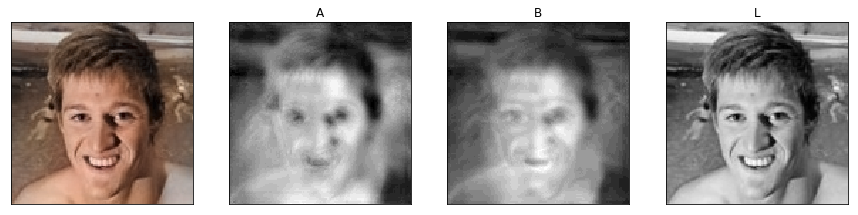

predy 123.545654 151.25299 133.08035 (1, 128, 128, 2)
hue: 125.416824 147.5947 132.77528
sat: 123.545654 151.25299 133.3854
predy uint8 123 151 132.58163452148438
hue uint8 125 147 132.27813720703125


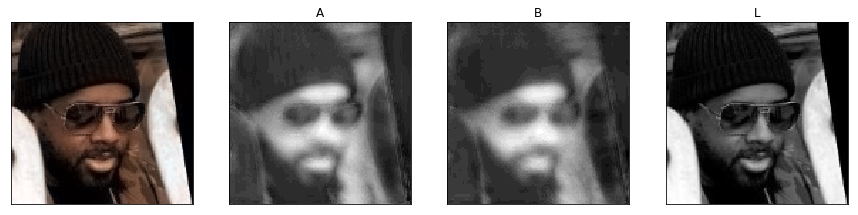

predy 126.93164 156.69057 136.37863 (1, 128, 128, 2)
hue: 127.2687 153.017 135.43369
sat: 126.93164 156.69057 137.3236
predy uint8 126 156 135.87942504882812
hue uint8 127 153 134.94525146484375


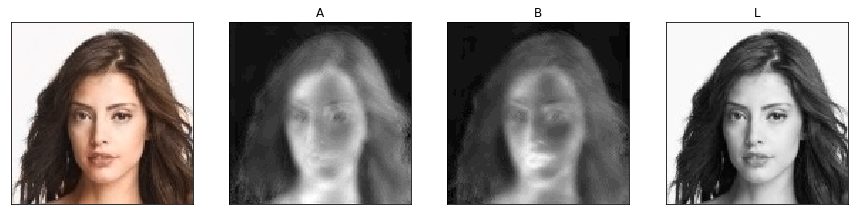

predy 126.89461 153.50784 137.8783 (1, 128, 128, 2)
hue: 127.550095 152.32379 136.066
sat: 126.89461 153.50784 139.69058
predy uint8 126 153 137.3763427734375
hue uint8 127 152 135.56341552734375


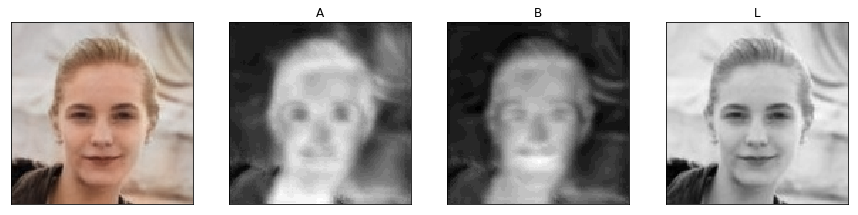

predy 126.63214 157.90813 136.98932 (1, 128, 128, 2)
hue: 126.63214 154.40817 135.64905
sat: 127.56742 157.90813 138.32959
predy uint8 126 157 136.48898315429688
hue uint8 126 154 135.14654541015625


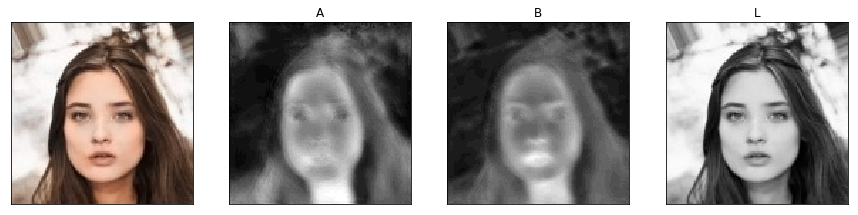

predy 124.67961 155.87164 134.78415 (1, 128, 128, 2)
hue: 126.6721 153.93578 134.61258
sat: 124.67961 155.87164 134.95573
predy uint8 124 155 134.27911376953125
hue uint8 126 153 134.07415771484375


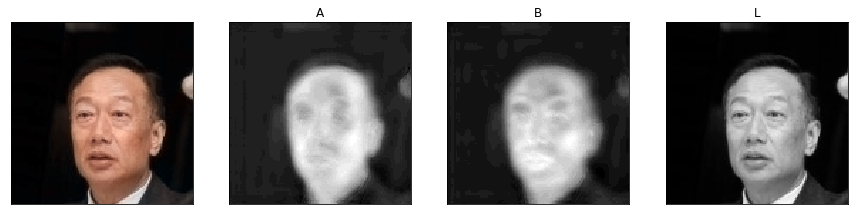

predy 126.89806 158.96802 138.20209 (1, 128, 128, 2)
hue: 126.89806 154.74533 136.50958
sat: 126.96637 158.96802 139.89459
predy uint8 126 158 137.70166015625
hue uint8 126 154 136.0057373046875


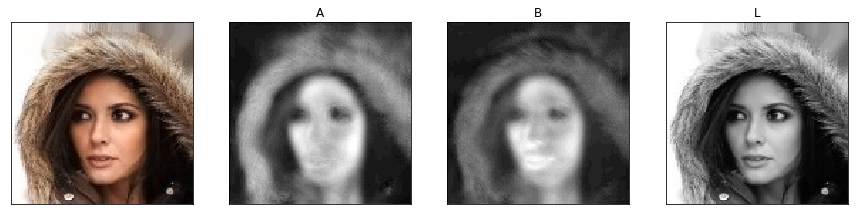

predy 126.9115 158.22235 139.1039 (1, 128, 128, 2)
hue: 127.966446 153.01454 137.60184
sat: 126.9115 158.22235 140.60596
predy uint8 126 158 138.60479736328125
hue uint8 127 153 137.09942626953125


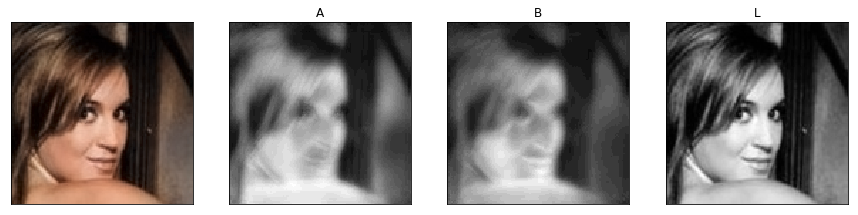

predy 125.8748 156.8171 136.18321 (1, 128, 128, 2)
hue: 127.82017 153.94087 135.56422
sat: 125.8748 156.8171 136.80222
predy uint8 125 156 135.6893310546875
hue uint8 127 153 135.0693359375


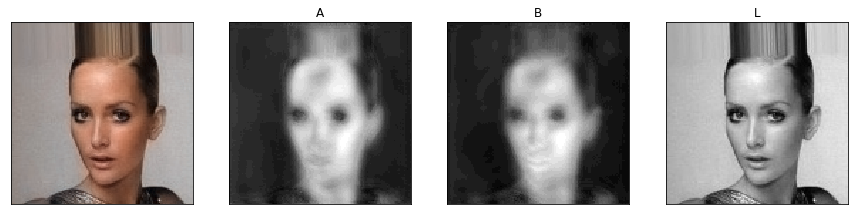

predy 125.19963 156.70404 136.77817 (1, 128, 128, 2)
hue: 126.81166 151.55894 135.38121
sat: 125.19963 156.70404 138.17511
predy uint8 125 156 136.26953125
hue uint8 126 151 134.87530517578125


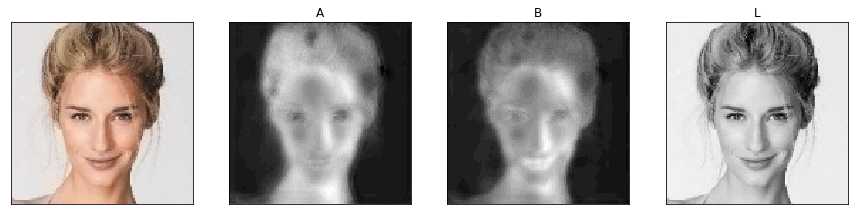

predy 126.11484 151.91211 134.44096 (1, 128, 128, 2)
hue: 127.23464 149.45233 133.93939
sat: 126.11484 151.91211 134.94254
predy uint8 126 151 133.939453125
hue uint8 127 149 133.42181396484375


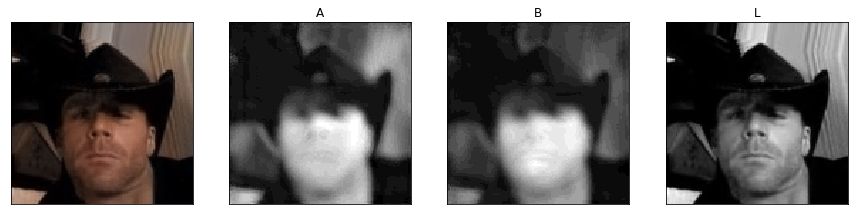

predy 125.47777 155.42982 141.61777 (1, 128, 128, 2)
hue: 126.956276 152.50342 139.48822
sat: 125.47777 155.42982 143.74733
predy uint8 125 155 141.1138916015625
hue uint8 126 152 138.98516845703125


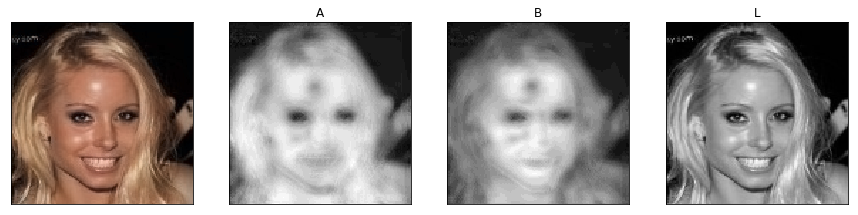

predy 124.03964 154.3108 137.33229 (1, 128, 128, 2)
hue: 125.99656 149.96881 136.15483
sat: 124.03964 154.3108 138.50975
predy uint8 124 154 136.83111572265625
hue uint8 125 149 135.6553955078125


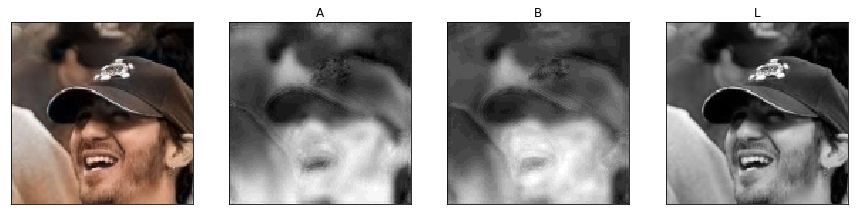

predy 127.243 155.65886 138.46964 (1, 128, 128, 2)
hue: 127.243 155.24168 137.41063
sat: 127.24329 155.65886 139.52861
predy uint8 127 155 137.96505737304688
hue uint8 127 155 136.91156005859375


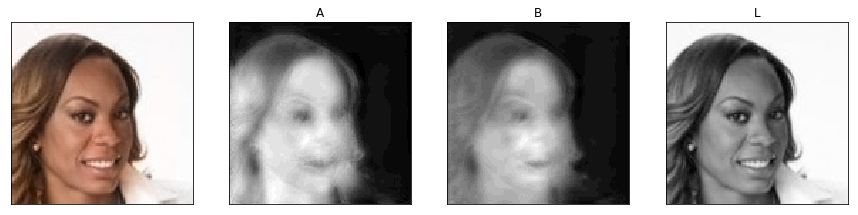

predy 125.584236 155.41017 135.67743 (1, 128, 128, 2)
hue: 127.02031 155.27948 134.91498
sat: 125.584236 155.41017 136.43988
predy uint8 125 155 135.17626953125
hue uint8 127 155 134.41796875


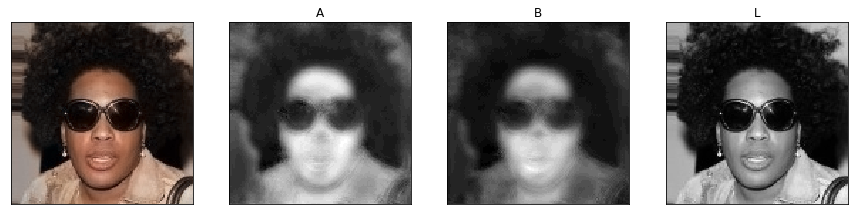

predy 125.73299 157.69275 139.57938 (1, 128, 128, 2)
hue: 126.726524 153.24664 137.17297
sat: 125.73299 157.69275 141.98578
predy uint8 125 157 139.08062744140625
hue uint8 126 153 136.67572021484375


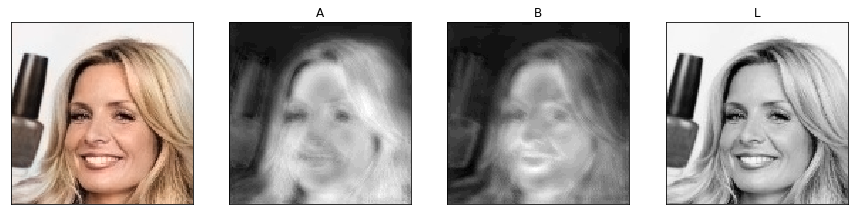

predy 127.77832 158.08643 137.09293 (1, 128, 128, 2)
hue: 129.03474 153.88441 136.16742
sat: 127.77832 158.08643 138.01846
predy uint8 127 158 136.59249877929688
hue uint8 129 153 135.6661376953125


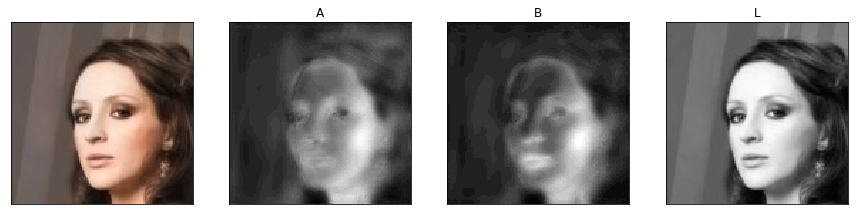

predy 126.51964 159.3818 138.65695 (1, 128, 128, 2)
hue: 127.224686 152.50153 136.03079
sat: 126.51964 159.3818 141.28313
predy uint8 126 159 138.15875244140625
hue uint8 127 152 135.537841796875


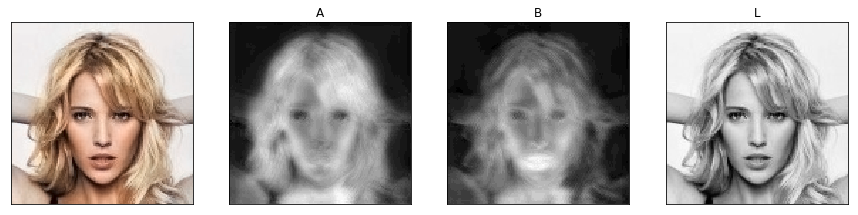

predy 125.64037 155.6108 137.46262 (1, 128, 128, 2)
hue: 127.232025 153.32913 136.20114
sat: 125.64037 155.6108 138.72409
predy uint8 125 155 136.96441650390625
hue uint8 127 153 135.70477294921875


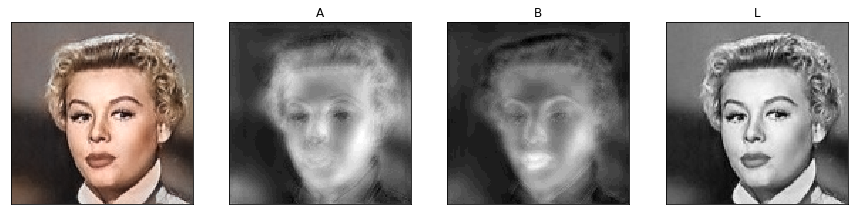

predy 126.20971 150.70741 133.0448 (1, 128, 128, 2)
hue: 128.08144 147.13571 132.92441
sat: 126.20971 150.70741 133.16519
predy uint8 126 150 132.53680419921875
hue uint8 128 147 132.4102783203125


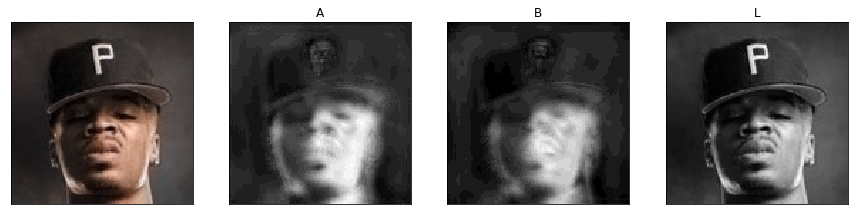

predy 122.150566 155.79324 137.05563 (1, 128, 128, 2)
hue: 125.896126 153.23476 136.5545
sat: 122.150566 155.79324 137.5568
predy uint8 122 155 136.5528564453125
hue uint8 125 153 136.05322265625


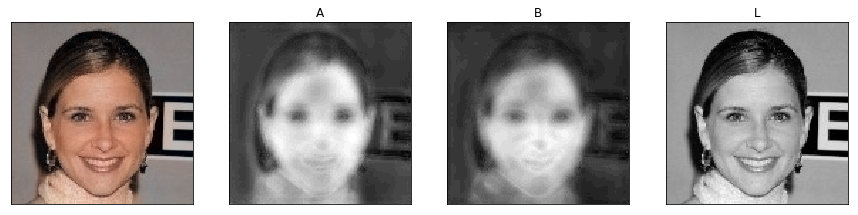

predy 124.82825 153.90173 137.74908 (1, 128, 128, 2)
hue: 126.259445 153.12103 135.8564
sat: 124.82825 153.90173 139.64175
predy uint8 124 153 137.24465942382812
hue uint8 126 153 135.35113525390625


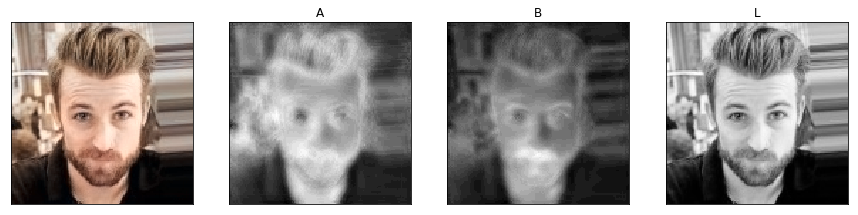

predy 126.86903 153.74841 133.77878 (1, 128, 128, 2)
hue: 127.471245 150.10115 133.29077
sat: 126.86903 153.74841 134.2668
predy uint8 126 153 133.2877197265625
hue uint8 127 150 132.79815673828125


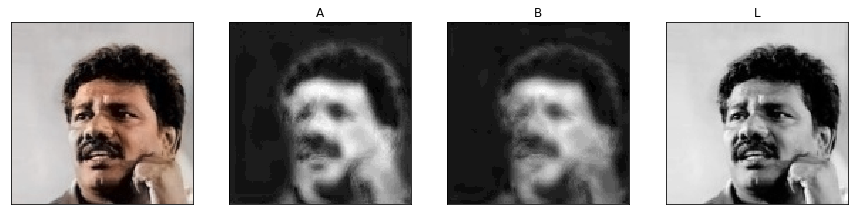

predy 125.75705 154.93735 136.67258 (1, 128, 128, 2)
hue: 126.62255 150.01439 135.44008
sat: 125.75705 154.93735 137.90506
predy uint8 125 154 136.15682983398438
hue uint8 126 150 134.89471435546875


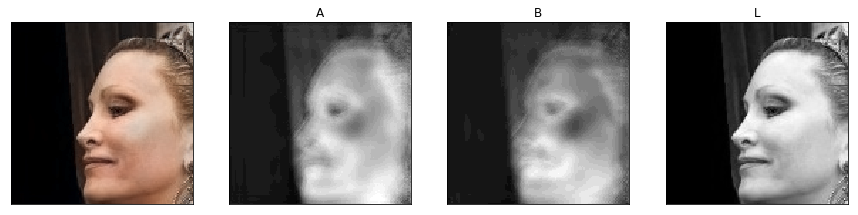

predy 123.937836 155.04721 135.8233 (1, 128, 128, 2)
hue: 126.05018 151.9551 135.27753
sat: 123.937836 155.04721 136.3691
predy uint8 123 155 135.32412719726562
hue uint8 126 151 134.77569580078125


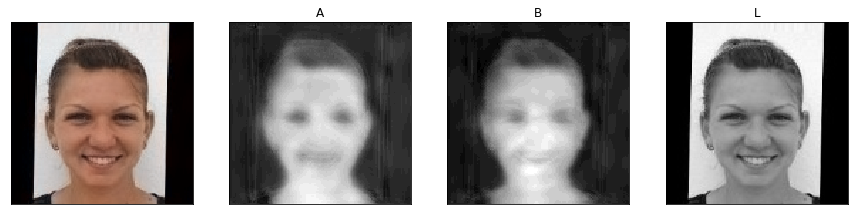

predy 122.86691 154.90715 134.95604 (1, 128, 128, 2)
hue: 125.904465 154.58205 134.82498
sat: 122.86691 154.90715 135.08711
predy uint8 122 154 134.44955444335938
hue uint8 125 154 134.31805419921875


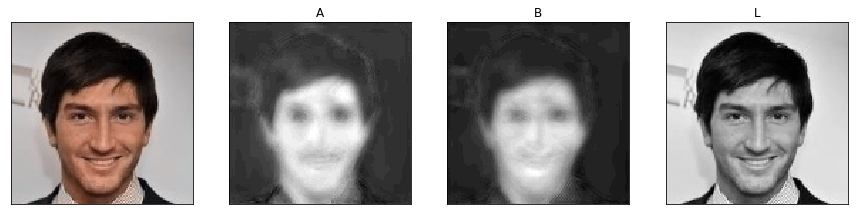

predy 125.928444 155.16327 135.5625 (1, 128, 128, 2)
hue: 127.96522 151.43399 135.00903
sat: 125.928444 155.16327 136.11597
predy uint8 125 155 135.06277465820312
hue uint8 127 151 134.507080078125


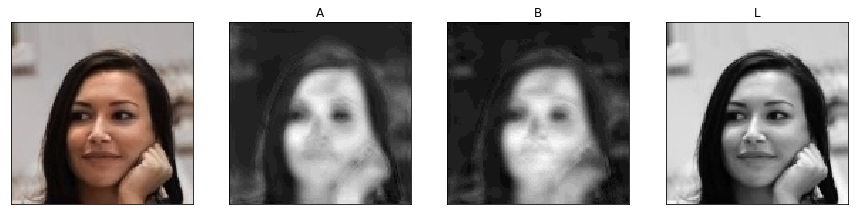

predy 126.70599 155.25641 137.31493 (1, 128, 128, 2)
hue: 127.45668 153.27933 136.364
sat: 126.70599 155.25641 138.26584
predy uint8 126 155 136.81466674804688
hue uint8 127 153 135.8616943359375


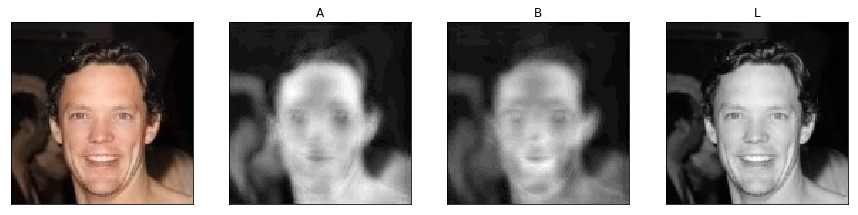

predy 124.88824 157.37935 134.49486 (1, 128, 128, 2)
hue: 126.816444 152.68959 134.08195
sat: 124.88824 157.37935 134.90778
predy uint8 124 157 133.99307250976562
hue uint8 126 152 133.5858154296875


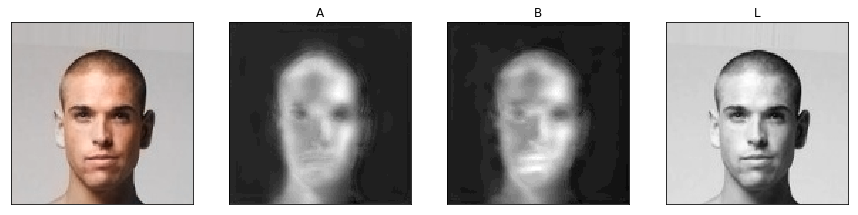

predy 120.62116 155.2228 133.92053 (1, 128, 128, 2)
hue: 124.81338 150.0198 133.50694
sat: 120.62116 155.2228 134.3341
predy uint8 120 155 133.42190551757812
hue uint8 124 150 133.00823974609375


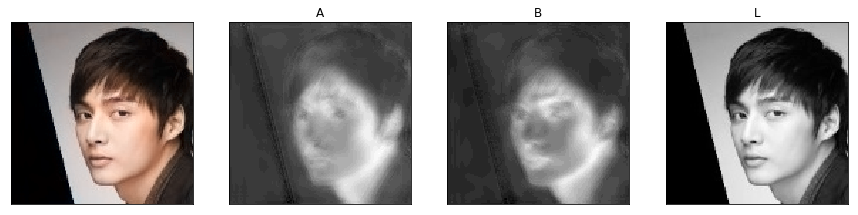

predy 127.08725 151.06131 134.83932 (1, 128, 128, 2)
hue: 128.374 150.45113 134.1423
sat: 127.08725 151.06131 135.53635
predy uint8 127 151 134.34017944335938
hue uint8 128 150 133.6436767578125


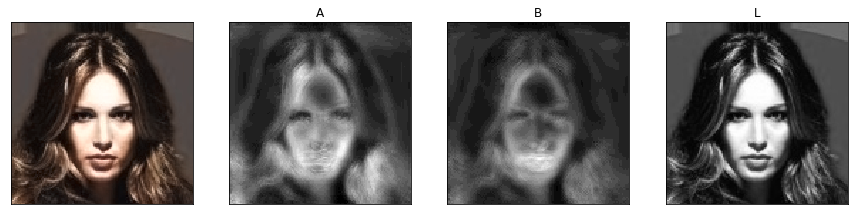

predy 124.7866 154.18222 135.44925 (1, 128, 128, 2)
hue: 125.470985 153.79858 134.80634
sat: 124.7866 154.18222 136.09213
predy uint8 124 154 134.95947265625
hue uint8 125 153 134.33111572265625


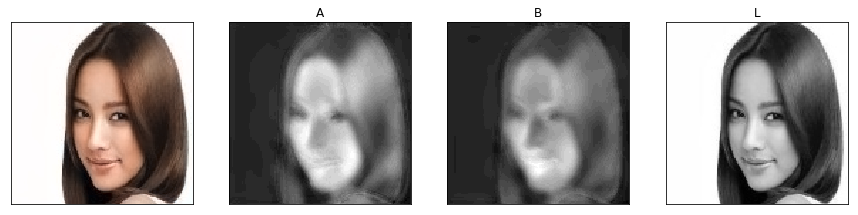

predy 124.86478 151.61868 136.60587 (1, 128, 128, 2)
hue: 126.656334 150.31758 136.07675
sat: 124.86478 151.61868 137.13496
predy uint8 124 151 136.10372924804688
hue uint8 126 150 135.55511474609375


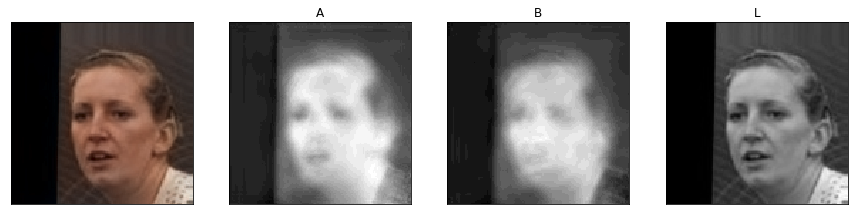

predy 126.946594 153.82285 136.8745 (1, 128, 128, 2)
hue: 127.14008 150.08401 136.08038
sat: 126.946594 153.82285 137.66861
predy uint8 126 153 136.37783813476562
hue uint8 127 150 135.58746337890625


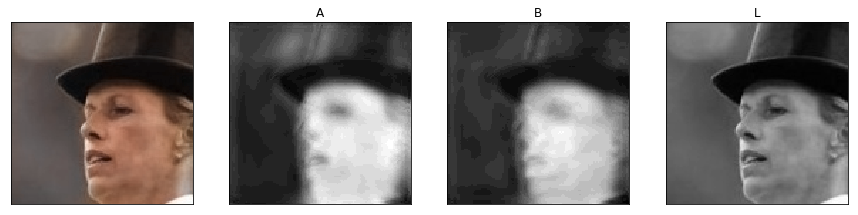

predy 126.80584 154.04816 137.38843 (1, 128, 128, 2)
hue: 127.14132 150.17429 136.08923
sat: 126.80584 154.04816 138.68762
predy uint8 126 154 136.88665771484375
hue uint8 127 150 135.5909423828125


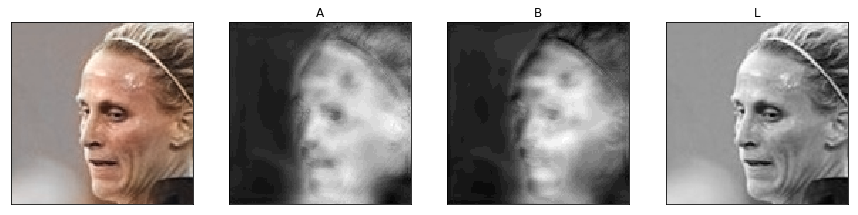

predy 121.40776 152.30489 134.61807 (1, 128, 128, 2)
hue: 123.70116 149.21567 134.1305
sat: 121.40776 152.30489 135.10565
predy uint8 121 152 134.1199951171875
hue uint8 123 149 133.63262939453125


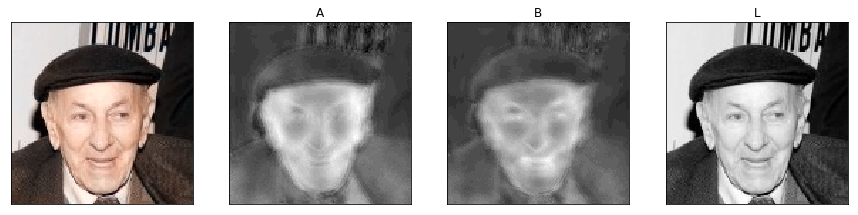

In [175]:
print('countEpochs',countEpochs)
predictions(trainSize, 40)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    y = np.dstack([params['mean'][...,0].astype('uint8'), params['mean'][...,1].astype('uint8'), x.astype('uint8')])
    #print(y.shape, params['mean'][...,0].min(), params['mean'][...,0].max(), x.dtype, x.min(), x.max())
    # plt.imshow(x - params['mean'][...,2])
    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['hue','saturation','value'][i-1])
        plt.imshow(params['mean'][...,i-1])
    plt.show()
    print("Input value with mean hue and mean saturation:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [ ]:
model.save(f'data/{NAME}.h5')

In [ ]:
print(training_generator[0][0][0,...,0].shape)
print('sanity check - mean[...,2] is val mean:')
ttt =(training_generator[0][0][6,...,0] - params['mean'][...,2]  ) / np.sqrt(params['var'][...,2])
plt.imshow(ttt) 
ttt.min(), ttt.max(), ttt.mean()

In [ ]:
print('mean hue, saturation, value:')
h,s,v = params['mean'][...,0], params['mean'][...,1], params['mean'][...,2]
showHsv(np.dstack([h,s,v]).astype('uint8'))
for i,c in enumerate([h,s,v]):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(c)

plt.show()


In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
batch=55
print('testing channel ranges:')
print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
print(training_generator[batch][1].shape)
h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
v = training_generator[batch][0][0,...].astype('uint8')
y = np.dstack([h , s, v ] )
showHsv(y )
print(h.min(), h.max())
plt.imshow(h)

In [ ]:
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [121]:
def demo(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (128,128))
    cv2.imwrite("./tmp.jpg", img)
    predictFromImage("./tmp.jpg", True)
    try:
        os.remove("./tmp.jpg")
    except OSError:
        pass
